# Pancancer Survival Analysis 

This notebook tests survival risk for a driver mutation. This survival analysis includes: Kaplan Meier plot, Multivariate Survival Risk plot, and the Cox's Proportional Hazard Test. We start with GBM and then move to a pancancer analysis.

Imports

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['follow_up_vital_status', 'follow_up_days']
        #cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS'] # followup cols
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols
    
    # csv contains days_between_last_contact_or_death
    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 

    return cols

In [4]:
def get_most_recent_last_contact_df(survival_in):
    d = {}
    df = survival_in[['days_to_last_contact']]
    index_list = list(df.index.unique())
    for i in index_list:
        one_index_df = df.loc[[i]]
        # Get the latest number when duplicate records
        most_recent = one_index_df['days_to_last_contact'].max() # get most recent (highest num)
        d[i] = most_recent
        
    last_contact_df = pd.DataFrame.from_dict(d, orient='index', columns=['days_to_last_contact'])
    last_contact_df.index.name = 'Patient_ID'
    
    return last_contact_df   

In [5]:
def get_df_clinical(ca):
    cols = get_survival_cols(ca)
    
    clin = ca.get_clinical(tissue_type = 'tumor')
    df = clin[cols]
    if ca.get_cancer_type() in ('hnscc'):
        survival_df = df.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact_or_death'}) 
    else: 
        survival_df = df.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact', cols[2]: 'days_to_death'})
    survival_df = survival_df.dropna(subset = ['vital_status']) # keep samples with survival data
    
    return survival_df

In [6]:
def get_df_followup(ca):
    cols = get_survival_cols(ca)
    followup = ca.get_followup(tissue_type = 'tumor')
    df = followup[cols]
    df = df.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact', cols[2]: 'days_to_death'})

    v = df[['vital_status']].dropna()
    vitals = v[~v.index.duplicated(keep='last')] # drop dup samples keeping last entry

    most_recent_last_contact = get_most_recent_last_contact_df(df) # get most recent days_to_last_contact
    d = df[['days_to_death']].dropna()
    death = d[~d.index.duplicated(keep='last')]

    days_df = death.merge(most_recent_last_contact, on = 'Patient_ID', how = 'outer')
    survival_df = days_df.merge(vitals, on = 'Patient_ID', how = 'left')
    return survival_df

In [7]:
# fix colon vital status (not all death events recorded right)
# brca 4 vals to 2 vals

def get_df_csv(cancer_obj):
    cancer = cancer_obj.get_cancer_type()
    
    # get days_to_last_contact_or_death from csv
    if cancer in ('colon'):
        days = pd.read_csv('followup_days/CO_days_to_last_contact_or_death.csv')    
    elif cancer in ('brca'): 
        days = pd.read_csv('followup_days/BR_days_to_last_contact_or_death.csv') 
    days = days.set_index('Patient_ID')
    
    # get vital status col name
    cols = get_survival_cols(cancer_obj)

    # get vital status from followup
    followup = cancer_obj.get_followup(tissue_type = 'tumor')
    followup = followup.rename(columns = {cols[0]: 'vital_status'}) #(at time of last contact)
    v = followup[['vital_status']].dropna()
    vitals = v[~v.index.duplicated(keep='last')] # drop dup samples keeping last entry
    
    # make vital_status binary like other cancers
    if cancer in ('brca'):
        vitals['vital_status'] = vitals['vital_status'].replace('Alive', 'Living')
        vitals['vital_status'] = vitals['vital_status'].replace('Dead', 'Deceased')
    
    survival_df = days.merge(vitals, on = 'Patient_ID', how = 'left')
    return survival_df

# Step 1: Import cancer data

In [8]:
g = cptac.Gbm()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()
l = cptac.Luad()
hn = cptac.Hnscc()
ls = cptac.Lscc()
en = cptac.Endometrial()
#kidney = cptac.Ccrcc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


# Pan-cancer Analysis

In [9]:
cancer_obj = {'GBM':g, 'HNSCC':hn, 'LUAD':l, 'BR':b, 'CO':col, 'OV':o, 'EC': en}

In [10]:
data_in_clinical = ('GBM', 'OV', 'HNSCC') # HNSCC also has data in followup (already merged in clinical)
data_in_followup = ('LUAD', 'EC')
data_in_csv = ('CO', 'BR') # lscc has no followup data yet

survival_dfs = {}

for cancer in cancer_obj:
    print(cancer)
    ca = cancer_obj[cancer]
    
    # Get driver status
    has_driver = pd.read_csv('has_driver_PTEN/'+cancer+ '_has_driver.csv', index_col=0)

    # Get survival data from different sources  
    if cancer in data_in_clinical:
        survival_df = get_df_clinical(ca)
    elif cancer in data_in_followup:
        survival_df = get_df_followup(ca)
    elif cancer in data_in_csv:
        survival_df = get_df_csv(ca)
    
    # merge driver status with survival 
    mut_survival = survival_df.join(has_driver, on = 'Patient_ID', how = 'left') 
    mut_survival = mut_survival.dropna(subset = ['has_driver'])
    print('len mut_survival:', len(mut_survival))
    print(mut_survival.vital_status.value_counts(), '\n')

    survival_dfs[cancer] = mut_survival

GBM
len mut_survival: 91
Deceased    47
Living      44
Name: vital_status, dtype: int64 

HNSCC
len mut_survival: 98
Living      84
Deceased    14
Name: vital_status, dtype: int64 

LUAD
len mut_survival: 95
Living      82
Deceased    13
Name: vital_status, dtype: int64 

BR
len mut_survival: 87
Living      85
Deceased     2
Name: vital_status, dtype: int64 

CO
len mut_survival: 98
Living      91
Deceased     7
Name: vital_status, dtype: int64 

OV
len mut_survival: 64
Living      59
Deceased     5
Name: vital_status, dtype: int64 

EC
len mut_survival: 68
Living      62
Deceased     6
Name: vital_status, dtype: int64 



In [11]:
# Format dfs for plotting 
formatted_dfs = {}

for cancer in survival_dfs:
    print(cancer)
    mut_survival = survival_dfs[cancer]
    
    #Make the vital_status column boolean
    mut_survival['vital_status'] = mut_survival['vital_status'].replace('Living', False)
    mut_survival['vital_status'] = mut_survival['vital_status'].replace('Deceased', True)
    mut_survival['vital_status'] = mut_survival['vital_status'].astype('bool') # careful: nan vals will change to bool
    print(mut_survival['vital_status'].value_counts(), '\n')

    # map numeric values to correspond with mutation status
    mutation_map = {False : 0, True : 1}
    mut_survival['has_driver'] = mut_survival['has_driver'].map(mutation_map)
    
    # Create one column with days between last contact or death
    if cancer not in data_in_csv and cancer not in ('HNSCC'):
        days = ['days_to_last_contact', 'days_to_death']
        mut_survival = mut_survival.assign(days_to_last_contact_or_death = mut_survival[days].sum(1)).drop(days, 1)

    #Then we will drop missing values, as missing values 
    #will throw an error in the functions we will use in lifelines.
    df_clean = mut_survival.dropna(axis=0, how='any').copy()
    
    formatted_dfs[cancer] = df_clean

GBM
True     47
False    44
Name: vital_status, dtype: int64 

HNSCC
False    84
True     14
Name: vital_status, dtype: int64 

LUAD
False    82
True     13
Name: vital_status, dtype: int64 

BR
False    85
True      2
Name: vital_status, dtype: int64 

CO
False    91
True      7
Name: vital_status, dtype: int64 

OV
False    59
True      5
Name: vital_status, dtype: int64 

EC
False    62
True      6
Name: vital_status, dtype: int64 



# BR

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\lifelines\utils\__init__.py:1114: ConvergenceWarning: Column has_driver have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['vital_status'].astype(bool)
>>> print(df.loc[events, 'has_driver'].var())
>>> print(df.loc[~events, 'has_driver'].var())

A very low variance means that the column has_driver completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\lifelines\fitters\coxph_fitter.py:1265: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.423. This may imply non-unique solutions to t

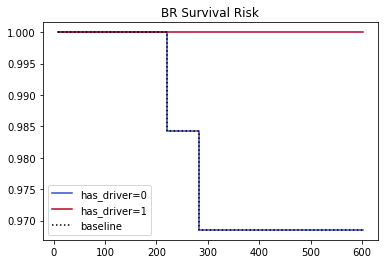

In [12]:
br_df = formatted_dfs['BR']

cph = CoxPHFitter()
cph.fit(br_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "BR Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [13]:
# check assumptions
print(cph.check_assumptions(br_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 87 total observations, 85 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 2
   partial log-likelihood = -8.270
         time fit was run = 2020-11-14 03:53:39 UTC
                    model = untransformed variables

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
has_driver -15.193      0.000   2624.073        -5158.282         5127.895                0.000                  inf

                z     p   -log2(p)
covariate                         
has_driver -0.006 0.995      0.007
---
Concordance = 0.613
Partial AIC = 18.541
log-likelihood ratio test = 1.012 on 1 df
-log2(p) of ll-ratio test = 1.670

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 87 total observations, 85 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.00 1.00      0.00

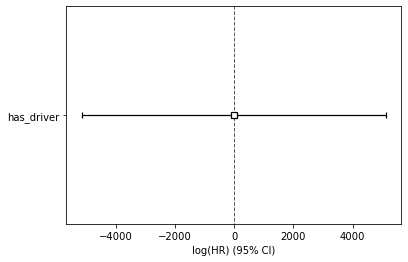

In [14]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, br_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# CO

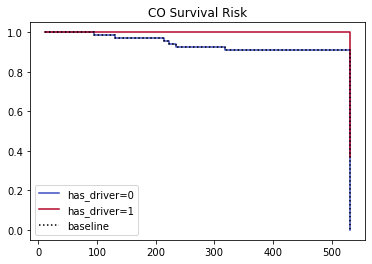

In [15]:
co_df = formatted_dfs['CO']

cph = CoxPHFitter()
cph.fit(co_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "CO Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [16]:
print(cph.check_assumptions(co_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 98 total observations, 91 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 98
number of events observed = 7
   partial log-likelihood = -25.019
         time fit was run = 2020-11-14 03:53:39 UTC
                    model = untransformed variables

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
has_driver -16.277      0.000   2338.832        -4600.303         4567.749                0.000                  inf

                z     p   -log2(p)
covariate                         
has_driver -0.007 0.994      0.008
---
Concordance = 0.633
Partial AIC = 52.039
log-likelihood ratio test = 3.664 on 1 df
-log2(p) of ll-ratio test = 4.169

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 98 total observations, 91 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.00 1.00      0.00

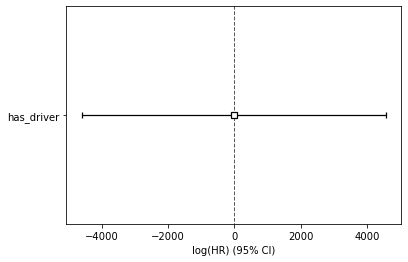

In [17]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, co_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# EC

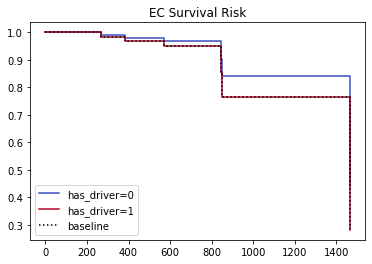

In [18]:
ec_df = formatted_dfs['EC']

cph = CoxPHFitter()
cph.fit(ec_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "EC Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [19]:
print(cph.check_assumptions(ec_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 68 total observations, 62 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 68
number of events observed = 6
   partial log-likelihood = -17.015
         time fit was run = 2020-11-14 03:53:40 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver  0.433      1.543      1.124           -1.769            2.636                0.171               13.954

               z     p   -log2(p)
covariate                        
has_driver 0.386 0.700      0.515
---
Concordance = 0.601
Partial AIC = 36.030
log-likelihood ratio test = 0.161 on 1 df
-log2(p) of ll-ratio test = 0.540

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 68 total observations, 62 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.27 0.60      0.73

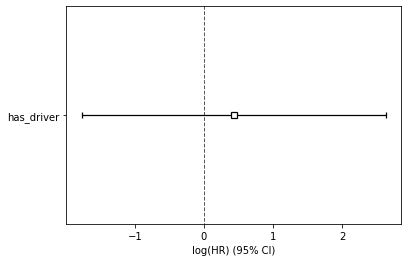

In [20]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, ec_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# GBM

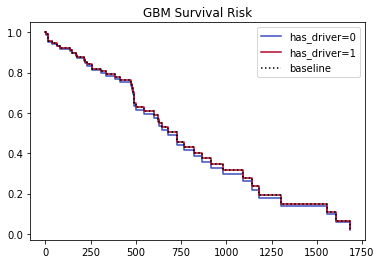

In [21]:
gbm_df = formatted_dfs['GBM']

cph = CoxPHFitter()
cph.fit(gbm_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "GBM Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [22]:
print(cph.check_assumptions(gbm_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 91 total observations, 44 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 91
number of events observed = 47
   partial log-likelihood = -158.735
         time fit was run = 2020-11-14 03:53:40 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver -0.047      0.954      0.417           -0.864            0.769                0.422                2.158

                z     p   -log2(p)
covariate                         
has_driver -0.114 0.909      0.137
---
Concordance = 0.498
Partial AIC = 319.470
log-likelihood ratio test = 0.013 on 1 df
-log2(p) of ll-ratio test = 0.136

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 91 total observations, 44 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.16 0.69      0.54

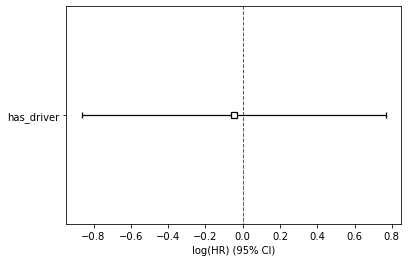

In [23]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, gbm_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# HNSCC

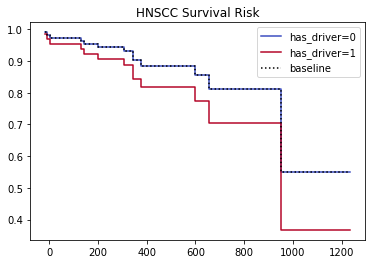

In [24]:
h_df = formatted_dfs['HNSCC']

cph = CoxPHFitter()
cph.fit(h_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "HNSCC Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [25]:
print(cph.check_assumptions(h_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 98 total observations, 84 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 98
number of events observed = 14
   partial log-likelihood = -51.981
         time fit was run = 2020-11-14 03:53:41 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver  0.514      1.672      0.597           -0.655            1.683                0.519                5.383

               z     p   -log2(p)
covariate                        
has_driver 0.862 0.389      1.362
---
Concordance = 0.528
Partial AIC = 105.962
log-likelihood ratio test = 0.687 on 1 df
-log2(p) of ll-ratio test = 1.296

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 98 total observations, 84 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.54 0.46      1.11

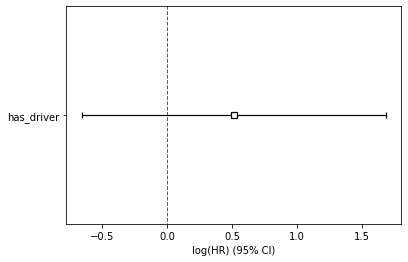

In [26]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, h_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# LUAD

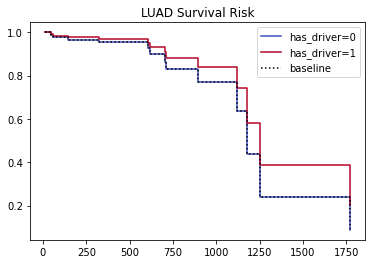

In [27]:
luad_df = formatted_dfs['LUAD']

cph = CoxPHFitter()
cph.fit(luad_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "LUAD Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [28]:
print(cph.check_assumptions(luad_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 95 total observations, 82 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 95
number of events observed = 13
   partial log-likelihood = -37.713
         time fit was run = 2020-11-14 03:53:41 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver -0.417      0.659      0.800           -1.985            1.150                0.137                3.159

                z     p   -log2(p)
covariate                         
has_driver -0.522 0.602      0.732
---
Concordance = 0.489
Partial AIC = 77.427
log-likelihood ratio test = 0.295 on 1 df
-log2(p) of ll-ratio test = 0.768

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 95 total observations, 82 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.24 0.63      0.68

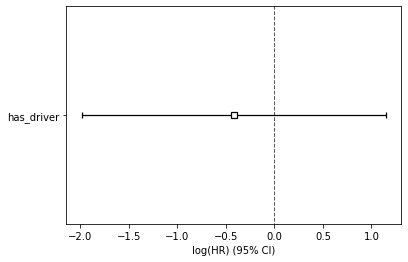

In [29]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, luad_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 

# OV

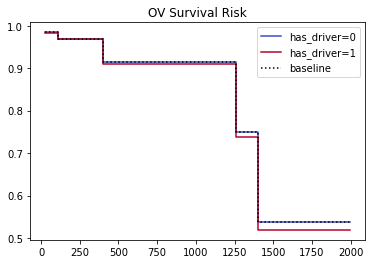

In [30]:
ov_df = formatted_dfs['OV']

cph = CoxPHFitter()
cph.fit(ov_df, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "OV Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)

In [31]:
# check assumptions
print(cph.check_assumptions(ov_df))

cph.print_summary(model="untransformed variables", decimals=3)

Proportional hazard assumption looks okay.
[]


<lifelines.CoxPHFitter: fitted with 64 total observations, 59 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 64
number of events observed = 5
   partial log-likelihood = -13.842
         time fit was run = 2020-11-14 03:53:42 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver  0.056      1.057      1.164           -2.225            2.337                0.108               10.349

               z     p   -log2(p)
covariate                        
has_driver 0.048 0.962      0.056
---
Concordance = 0.578
Partial AIC = 29.684
log-likelihood ratio test = 0.002 on 1 df
-log2(p) of ll-ratio test = 0.056

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 64 total observations, 59 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            1.14 0.29      1.80

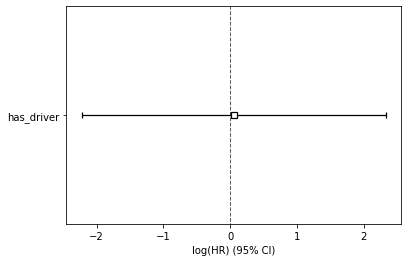

In [32]:
# Cox Proportional Hazard Test
results = proportional_hazard_test(cph, ov_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

# show the confidence interval for the hazard ratio
cph.plot() 